In [1]:
from pytorch_pretrained_biggan import (
    BigGAN,
    one_hot_from_names,
    truncated_noise_sample,
    convert_to_images,
)
import torch
from PIL import Image

In [2]:
modelBG = BigGAN.from_pretrained("biggan-deep-256").to('cuda')

In [3]:
def biggan(inp):
    truncation = 0.4
    try:
        class_vector = one_hot_from_names(inp, batch_size=len(inp))
        noise_vector = truncated_noise_sample(
            truncation=truncation, batch_size=len(inp)
        )
        noise_vector = torch.from_numpy(noise_vector)
        class_vector = torch.from_numpy(class_vector)
        with torch.no_grad():
            output = modelBG(noise_vector.to('cuda'), class_vector.to('cuda'), truncation)
    except:
        inp = ["cat"]
        class_vector = torch.from_numpy(one_hot_from_names(inp, batch_size=len(inp))).cuda()
        noise_vector = torch.from_numpy(
            truncated_noise_sample(truncation=truncation, batch_size=len(inp))
        ).cuda()
        with torch.no_grad():
            output = modelBG(noise_vector, class_vector, truncation)

    return convert_to_images(output.cpu())[0]

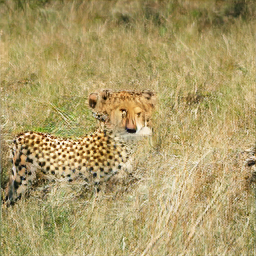

In [6]:
biggan(['Cheetah'])

In [7]:
import torchvision
import requests
import numpy as np
model_mask =  torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval().cuda()
detect_labels = {
    int(key): value
    for (key, value) in requests.get(
        "https://gist.githubusercontent.com/RehanSD/6f74a9992848e25658e091148ee20e17/raw/fae1f9f3ee0c3eb20ca9829e99cd8b616f22fa45/cocolabels.json"
    )
    .json()
    .items()
}

In [8]:
def get_bounding_boxes(output):
    """Yield Rectangle object from output string"""
    import matplotlib.patches as patches

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for c, m in zip(colors, output):
        cat, left, bottom, right, top = m
        left, bottom, right, top = float(left), float(bottom), float(right), float(top)
        yield patches.Rectangle((left,bottom), right-left, top-bottom, linewidth=1, facecolor='none', edgecolor=c,label=cat)
def mask(inp):
    image_tensor = torchvision.transforms.functional.to_tensor(inp)
    output = model_mask([image_tensor.cuda()])
    labels = output[0]['labels'].cpu().detach().numpy()
    labels = np.array([detect_labels[i] for i in labels])
    boxes = boxes = output[0]['boxes'].cpu().detach().numpy()
    out = np.hstack((labels[None].T, boxes))
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from io import StringIO
    fig,ax = plt.subplots(1, figsize=(10,8))
    ax.imshow(np.array(inp))
    for p in get_bounding_boxes(out):
        ax.add_patch(p) 
    fig.legend()
    buffer = StringIO()
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
    return pil_image

In [9]:
a = Image.open('arthur.jpg')

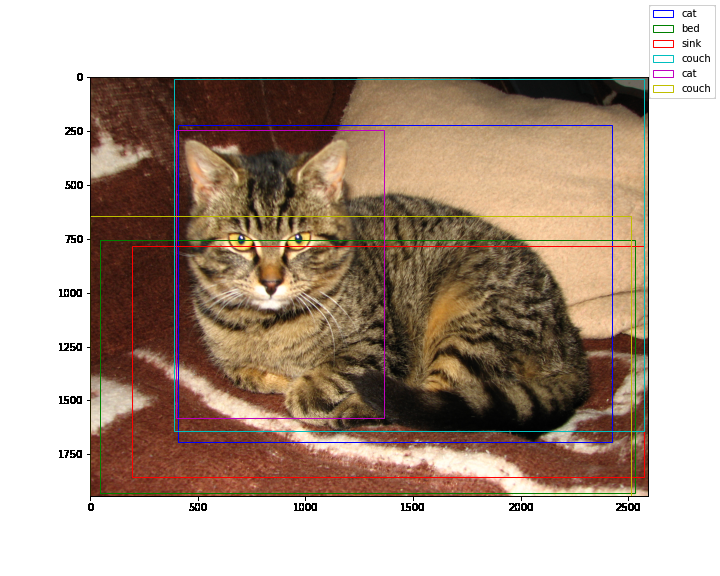

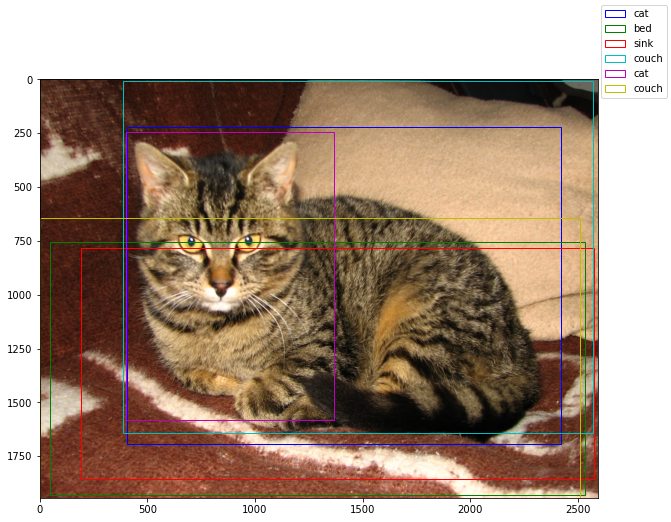

In [10]:
mask(a)

In [11]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
tokenizerG = GPT2Tokenizer.from_pretrained('gpt2')
modelG = GPT2LMHeadModel.from_pretrained('gpt2').to('cuda')

In [12]:
from tqdm import trange
import torch
import torch.nn.functional as F
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits
def sample_sequence(model, length, context, num_samples=1, temperature=1, top_k=0, top_p=0.0, repetition_penalty=1.0,
                    is_xlnet=False, is_xlm_mlm=False, xlm_mask_token=None, xlm_lang=None, device='cuda'):
    context = torch.tensor(context, dtype=torch.long, device=device)
    context = context.unsqueeze(0).repeat(num_samples, 1)
    generated = context
    with torch.no_grad():
        for _ in trange(length):

            inputs = {'input_ids': generated}
            if is_xlnet:
                # XLNet is a direct (predict same token, not next token) and bi-directional model by default
                # => need one additional dummy token in the input (will be masked), attention mask and target mapping (see model docstring)
                input_ids = torch.cat((generated, torch.zeros((1, 1), dtype=torch.long, device=device)), dim=1)
                perm_mask = torch.zeros((1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.float, device=device)
                perm_mask[:, :, -1] = 1.0  # Previous tokens don't see last token
                target_mapping = torch.zeros((1, 1, input_ids.shape[1]), dtype=torch.float, device=device)
                target_mapping[0, 0, -1] = 1.0  # predict last token
                inputs = {'input_ids': input_ids, 'perm_mask': perm_mask, 'target_mapping': target_mapping}

            if is_xlm_mlm and xlm_mask_token:
                # XLM MLM models are direct models (predict same token, not next token)
                # => need one additional dummy token in the input (will be masked and guessed)
                input_ids = torch.cat((generated, torch.full((1, 1), xlm_mask_token, dtype=torch.long, device=device)), dim=1)
                inputs = {'input_ids': input_ids}

            if xlm_lang is not None:
                inputs["langs"] = torch.tensor([xlm_lang] * inputs["input_ids"].shape[1], device=device).view(1, -1)

            outputs = model(**inputs)  # Note: we could also use 'past' with GPT-2/Transfo-XL/XLNet/CTRL (cached hidden-states)
            next_token_logits = outputs[0][0, -1, :] / (temperature if temperature > 0 else 1.)

            # reptition penalty from CTRL (https://arxiv.org/abs/1909.05858)
            for _ in set(generated):
                next_token_logits[_] /= repetition_penalty

            filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
            if temperature == 0: #greedy sampling:
                next_token = torch.argmax(filtered_logits).unsqueeze(0)
            else:
                next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
            generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
    return generated
def gpt2(inp, length=20):
    texts = []
    for i in inp:
        context_tokens = tokenizerG.encode(i)
        out = sample_sequence(model=modelG, context=context_tokens, length=length, temperature=0.7,top_k=0, top_p=0.9, repetition_penalty=1.0, device='cuda')
        out = out[0, len(context_tokens):].tolist()
        text = tokenizerG.decode(out, clean_up_tokenization_spaces=True, skip_special_tokens=True)
        texts.append(text)
    return texts

In [14]:
gpt2(['Tragedy is the highest form of', 'The world war II'], 40)

100%|██████████| 40/40 [00:00<00:00, 85.56it/s]


[' violence, with the fewest number of deaths. There have been roughly 20,000 documented homicides in the United States since the mid-1980s, according to the National Center for Injury Prevention and Control',
 ' was just beginning and the world was going to end. The British were making a move to the east coast and they were going to take over the whole of the world. And it was going to be']